Rented Bike Count - Upper outliers:
 2946    2401
2994    2402
3114    2401
3210    2404
3282    2692
        ... 
7746    2631
7818    2613
7842    2415
7866    2612
7890    2632
Name: Rented Bike Count, Length: 158, dtype: int64


KeyError: "None of [Index(['Wind speed (m/s)'], dtype='object')] are in the [columns]"

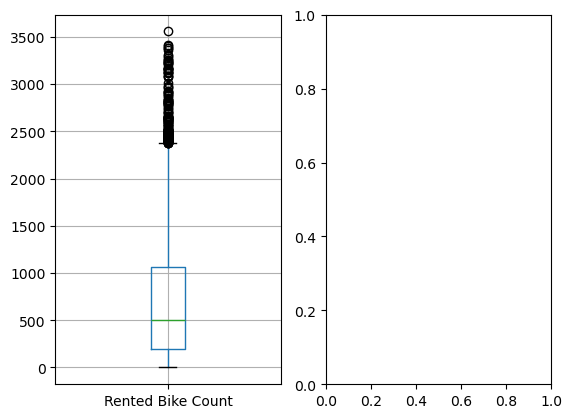

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Helper function
def findMinMax(data):
  q1 = data.quantile(0.25)
  q3 = data.quantile(0.75)
  min = q1 - 1.5 * (q3 - q1)
  max = q3 + 1.5 * (q3 - q1)
  return min, max

# Function to help us visualize the outliers. Produce boxplot and print out outliers
def getOutliers(data, features):
  for i, feature in enumerate(features, 1):
    plt.subplot(1,len(features),i)
    data[[feature]].boxplot()
    
    min, max = findMinMax(data[feature])
    outliers_lower = data[feature] < min
    outliers_upper = data[feature] > max
    
    if outliers_lower.any():
      print(feature, "- Lower outliers:\n", data.loc[outliers_lower, feature])
    if outliers_upper.any():
      print(feature, "- Upper outliers:\n", data.loc[outliers_upper, feature])

  plt.show()
  

# return az set of data with outliers removed
def removeOutliers(data, features):
  removeIdx = pd.Series([False] * len(data))
  for i, feature in enumerate(features):
    min, max = findMinMax(data[feature])
    outliers_lower = data[feature] < min
    outliers_upper = data[feature] > max
    
    removeIdx = removeIdx | outliers_lower | outliers_upper

  return data.loc[~removeIdx]
  


# Testing code
data = pd.DataFrame(pd.read_csv('./SeoulBikeData.csv'))
features = ['Rented Bike Count', 'Wind speed (m/s)']

getOutliers(data, features)

newData = removeOutliers(data, features)
getOutliers(newData, features)

In [23]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt


# Regression Model
class BatchRegression:
    def __init__(self):
        self.theta = None
    
    def execute_bgd(self, X, y, lr=0.01, epochs=20, batch_size=None, verbose=True):
        # size of the dataset
        m = X.shape[0]
        loss_history = []
        model = SGDRegressor(loss='squared_error', penalty='l2') # SGDRegressor() for partial_fit()
        
        for epoch in range(epochs):
            num_batches = m // batch_size if batch_size else 1
            # Iterate over the batches in each epoch
            for batch in range(num_batches):            
                #This line generates random indices from 0 to m (the total number of samples in the training set) without replacement. m is the size of the training dataset. The number of indices generated is equal to the batch_size.
                indices = np.random.choice(m, batch_size)
                # creates a mini-batch of input features for training
                X_batch = X[indices]
                # selects the corresponding subset of y for the mini-batch of input features
                y_batch = y[indices]

                model.partial_fit(X_batch, y_batch) # updates weights for us

            # print the Mean Squared Error (MSE) and store it in the loss_history list at certain intervals during the training process. 
            y_train_pred = model.fit(X)
            mse = mean_squared_error(y, y_train_pred)
            loss_history.append(mse)

        return loss_history

def predict_batch_gd(X, weights, bias):
    # prevent overflow
    return np.clip(np.dot(X, weights) + bias, -1e15, 1e15)

# batch gradient descent with l2 regularization
def grid_search_bgd(X, y, folds=10, degrees=[1, 2], 
                   batch_sizes=[32, 64],
                   learning_rates=[0.00001, 0.0001], 
                   reg_parameters=[0.00001, 0.0001]):
    
    # store best results
    best_mse = float('inf')
    best_params = None
    best_weights = None
    best_bias = None

    # need to convert to numpy arrays for compatibility w sklearn
    X_np = X.to_numpy() if hasattr(X, 'to_numpy') else X
    y_np = y.to_numpy() if hasattr(y, 'to_numpy') else y
    
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    results = []
    
    for degree in degrees:
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X_poly = poly.fit_transform(X_np)
        
        # scale X to prevent overflow
        X_scale = np.max(np.abs(X_poly))
        X_poly = X_poly / X_scale

        model = SGDRegressor()
        
        for batch_size in batch_sizes:
            for learning_rate in learning_rates:
                for reg_para in reg_parameters:
                    
                    fold_mses = []
                    
                    for train_index, val_index in kf.split(X_poly):
                        X_train, X_val = X_poly[train_index], X_poly[val_index]
                        y_train, y_val = y_np[train_index], y_np[val_index]
                        
                        model = BatchRegression()
                        model.execute_bgd(X_train, y_train)
                        # weights, bias, loss_history = partial_fit
                        
                        # y_pred = predict_batch_gd(X_val, weights, bias)
                        y_pred_train = model.predict(X_train)
                        y_pred_test = model.predict(X_test)
                        
                        mse = mean_squared_error(y_val_original, y_pred)
                        fold_mses.append(mse)
                    
                    if fold_mses:  # only if we have valid results
                        avg_mse = np.mean(fold_mses)
                        
                        results.append({
                            'degree': degree,
                            'batch_size': batch_size,
                            'learning_rate': learning_rate,
                            'reg_para': reg_para,
                            'mse': avg_mse
                        })
                        
                        if avg_mse < best_mse:
                            best_mse = avg_mse
                            best_params = {
                                'degree': degree,
                                'batch_size': batch_size,
                                'learning_rate': learning_rate,
                                'reg_para': reg_para
                            }
                            best_weights = weights * X_scale
                            best_bias = bias * y_scale
    
    if best_params is None:
        raise ValueError("No valid models found. Adjust hyperparameters.")
    
    print("\nBest parameters:")
    for param, value in best_params.items():
        print(f"{param}: {value}")
    print(f"Best Mean Squared Error: {best_mse:.4f}")
    
    return best_weights, best_bias, best_params, results

def plot_training_history(loss_history):
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history)
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()



# running code
# Get feature matrix X and target variable y
data = pd.DataFrame(pd.read_csv('./ProcessedData.csv'))

X = data.drop('Rented Bike Count', axis=1)
y = data['Rented Bike Count']

print("Shape of data:")
print("X shape:", X.shape)
print("y shape:", y.shape)

# Define the parameter grid 
param_grid = {
    'degrees': [1, 2],  # Start with linear model
    'batch_sizes': [16, 32, 64],  
    'learning_rates': [0.00001, 0.0001, 0.001],  # Much smaller learning rates
    'reg_parameters': [0.00001, 0.0001, 0.001]  # Smaller regularization parameters
}

# Perform grid search with cross validation
try:
    best_weights, best_bias, best_params, results = grid_search_bgd(
        X, y,
        folds=5,  # Reduced folds for faster testing
        **param_grid
    )

    # Print results summary
    print("\nTraining Results Summary:")
    print("-------------------------")
    for param, value in best_params.items():
        print(f"{param}: {value}")

    # Create predictions using best model
    poly = PolynomialFeatures(degree=best_params['degree'], include_bias=False)
    X_poly = poly.fit_transform(X)
    predictions = predict_batch_gd(X_poly, best_weights, best_bias)

    # Calculate and print final MSE
    final_mse = mean_squared_error(y, predictions)
    print(f"\nFinal MSE on full dataset: {final_mse:.4f}")

    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y, predictions, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    plt.xlabel('Actual Bike Rentals')
    plt.ylabel('Predicted Bike Rentals')
    plt.title('Actual vs Predicted Bike Rentals')
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"An error occurred: {str(e)}")

"""
#numpy .clip: https://numpy.org/doc/2.1/reference/generated/numpy.clip.html
#numpy .dot: https://numpy.org/doc/2.1/reference/generated/numpy.dot.html

"""

Shape of data:
X shape: (8159, 14)
y shape: (8159,)
An error occurred: name 'train' is not defined


'\n#numpy .clip: https://numpy.org/doc/2.1/reference/generated/numpy.clip.html\n#numpy .dot: https://numpy.org/doc/2.1/reference/generated/numpy.dot.html\n\n'